
<p style= "background-color:black;font-family:Georgia;color:gold;font-size:110%;text-align:center;border-radius:10px 10px;border-style:solid;border-width:3px;border-color:gold;"><b>Goal - The goal is to train a simple model for predicting the duration of a ride</b></p>

In [1]:
!python -V

Python 3.9.7


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

<p style= "background-color:blue;font-family:Georgia;color:#FFFFFF;font-size:110%;text-align:center;border-radius:10px 10px;border-style:solid;border-width:3px;border-color:white;"><b> Q1: Read the data for January. How many records are there?</b></p>

In [3]:
df = pd.read_parquet('fhv_tripdata_2021-01.parquet')

In [4]:
print('there are',df.shape[0], 'records')

there are 1154112 records




<p style= "background-color:blue;font-family:Georgia;color:#FFFFFF;font-size:110%;text-align:center;border-radius:10px 10px;border-style:solid;border-width:3px;border-color:white;"><b> Q2. Computing duration
Now let's compute the duration variable. It should contain the duration of a ride in minutes.<br>What's the average trip duration in January?

What's the average trip duration in January?</b></p>

In [5]:
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [6]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [7]:
print('The average trip duration in January is', round(df['duration'].mean(),2), 'mins')

The average trip duration in January is 19.17 mins


# Data preparation

/Users/ahmedadegunle/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

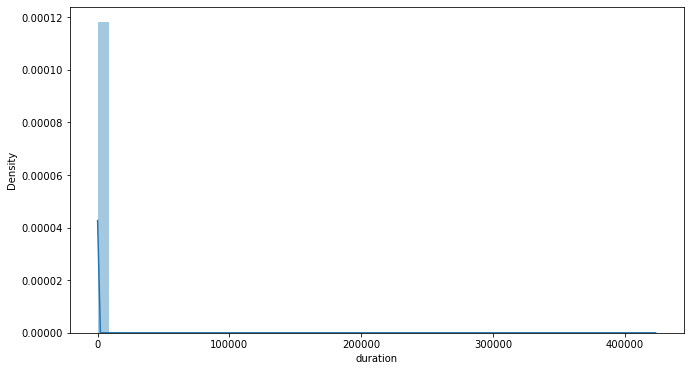

In [8]:
fig, ax = plt.subplots(figsize=(11,6))
sns.distplot(df['duration'])

## Comment: Duration is rightly skewed

In [9]:
new_df = df[(df.duration >= 1) & (df.duration <= 60)]

In [10]:
print(np.abs(new_df.shape[0] - df.shape[0]), 'records were dropped')

44286 records were dropped



<p style= "background-color:blue;font-family:Georgia;color:#FFFFFF;font-size:110%;text-align:center;border-radius:10px 10px;border-style:solid;border-width:3px;border-color:white;"><b> Q3. Missing values
The features we'll use for our model are the pickup and dropoff location IDs.<br>But they have a lot of missing values there. Let's replace them with "-1" <br>
What's the fractions of missing values for the pickup location ID? (Or the fraction of "-1"s after you filled the NAs)</b></p>


In [11]:
print(round(df['PUlocationID'].isnull().sum() * 100 / len(df['PUlocationID'])),'% is the fractions of missing values for the pickup location ID')

83 % is the fractions of missing values for the pickup location ID


In [12]:
new_df.fillna(-1, inplace = True)

/Users/ahmedadegunle/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [13]:
new_df.columns

Index(['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime',
       'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number',
       'duration'],
      dtype='object')


<p style= "background-color:blue;font-family:Georgia;color:#FFFFFF;font-size:110%;text-align:center;border-radius:10px 10px;border-style:solid;border-width:3px;border-color:white;"><b> Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model..<br>Turn the dataframe into a list of dictionaries
Fit a dictionary vectorizer<br>
Get a feature matrix from it
What's the dimensionality of this matrix? (The number of columns)</b></p>

In [14]:
categorical = ['PUlocationID', 'DOlocationID']
new_df[categorical] = new_df[categorical].astype(str)

train_dicts = new_df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

/Users/ahmedadegunle/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [15]:
print('The dimensionality of the matrix(no of columns) is', X_train.shape[1])

The dimensionality of the matrix(no of columns) is 525


<p style= "background-color:blue;font-family:Georgia;color:#FFFFFF;font-size:110%;text-align:center;border-radius:10px 10px;border-style:solid;border-width:3px;border-color:white;"><b> 
Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.
<br>Train a plain linear regression model with default parameters<br>
Calculate the RMSE of the model on the training data</b></p>

In [16]:
target = 'duration'
y_train = new_df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print('The RMSE of the model ',np.round(mean_squared_error(y_train, y_pred, squared=False)))

The RMSE of the model  11.0


<p style= "background-color:blue;font-family:Georgia;color:#FFFFFF;font-size:110%;text-align:center;border-radius:10px 10px;border-style:solid;border-width:3px;border-color:white;"><b> 
Q5.  Evaluating the model
Now lets apply this model to the validation dataset (Feb 2021).
<br>Whats the RMSE on validation?</b></p>

In [17]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.dropOff_datetime = pd.to_datetime(df.dropOff_datetime)
        df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [18]:
df_train = read_dataframe('./fhv_tripdata_2021-01.parquet')
df_val = read_dataframe('./fhv_tripdata_2021-02.parquet')

In [19]:
categorical = ['PUlocationID', 'DOlocationID']
df_train[categorical] = df_train[categorical].astype(str)

categorical = ['PUlocationID', 'DOlocationID']
df_val[categorical] = df_val[categorical].astype(str)

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [20]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

print('The RMSE of the Validation model',mean_squared_error(y_val, y_pred, squared=False))

The RMSE of the Validation model 11.014283219110846
